In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.setup_FOM import SimulationSetupFOM
from operators.FOM import psi_ln_aw, charge_density, D_matrix_inv_full, total_mass, total_momentum, total_energy_k, fft_

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Nonlinear (Strong) Landau damping 

In [4]:
setup = SimulationSetupFOM(Nx=50,
                           Nx_total=101,
                           Nv=100,
                           epsilon=0.3,
                           alpha_e=np.sqrt(2),
                           alpha_i=np.sqrt(2 / 1836),
                           u_e=0,
                           u_i=0,
                           L=4 * np.pi,
                           dt=0.01,
                           T0=0,
                           T=40,
                           nu=6,
                           col_type="hyper",
                           closure_type="truncation")

In [5]:
# matrices
D_inv = D_matrix_inv_full(Nx=setup.Nx, L=setup.L)

In [6]:
# ions (unperturbed)
C0_ions = np.zeros(setup.Nx_total)
C0_ions[setup.Nx] = 1 / setup.alpha_i

In [8]:
# velocity grid for plotting purposes
v = np.linspace(-4, 4, int(10**3))
# spatial grid 
x = np.linspace(0, setup.L, 2*setup.Nx+1)

# simulation results

In [9]:
skip = 100
# load the simulation results
sol_midpoint_u = np.load("data/nonlinear_landau/sol_u_" + str(setup.Nv) + "_closure_" + str(setup.closure_type) + "_collisions_" + str(setup.col_type) + ".npy")[:, ::skip]
sol_midpoint_t = np.load("data/nonlinear_landau/sol_t_" + str(setup.Nv) + "_closure_" + str(setup.closure_type) + "_collisions_" + str(setup.col_type) + ".npy")[::skip]

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(10100, 41)
(41,)


In [10]:
# initialize the electric potential
E_midpoint_coeff = np.zeros((setup.Nx_total, len(sol_midpoint_t)), dtype="complex128")
E_midpoint = np.zeros((2*setup.Nx + 1, len(sol_midpoint_t)))

In [11]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx_total, len(sol_midpoint_t)))
# save coefficients 
state_e_coeff = np.zeros((setup.Nv, setup.Nx_total, len(sol_midpoint_t)), dtype="complex128")

for ii in np.arange(0, len(sol_midpoint_t), 1):
    print("time = ", sol_midpoint_t[ii])
    for n in range(setup.Nv):
        # unwind the flattening to solve the Vlasov-Poisson system
        # electrons
        state_e_coeff[n, :, ii]  = sol_midpoint_u[n*setup.Nx_total: (n+1)*setup.Nx_total, ii]
        state_e_midpoint[n, :, ii] = fft_(coefficient=state_e_coeff[n, :, ii], Nx=setup.Nx, x=x, L=setup.L)

    # solve Poisson's equation to obtain an electric field
    E_midpoint_coeff[:, ii] = D_inv @ charge_density(C0_electron=sol_midpoint_u[:setup.Nx_total, ii], C0_ions=C0_ions,
                                                     alpha_e=setup.alpha_e, alpha_i=setup.alpha_i, 
                                                     q_e=setup.q_e, q_i=setup.q_i)
    
    E_midpoint[:-1, ii] = scipy.fft.irfft(E_midpoint_coeff[setup.Nx:, ii], norm="forward")
    E_midpoint[-1, ii] = E_midpoint[0, ii]

time =  0.0
time =  1.0
time =  2.0
time =  3.0
time =  4.0
time =  5.0
time =  6.0
time =  7.0
time =  8.0
time =  9.0
time =  10.0
time =  11.0
time =  12.0
time =  13.0
time =  14.0
time =  15.0
time =  16.0
time =  17.0
time =  18.0
time =  19.0
time =  20.0
time =  21.0
time =  22.0
time =  23.0
time =  24.0
time =  25.0
time =  26.0
time =  27.0
time =  28.0
time =  29.0
time =  30.0
time =  31.0
time =  32.0
time =  33.0
time =  34.0
time =  35.0
time =  36.0
time =  37.0
time =  38.0
time =  39.0
time =  40.0


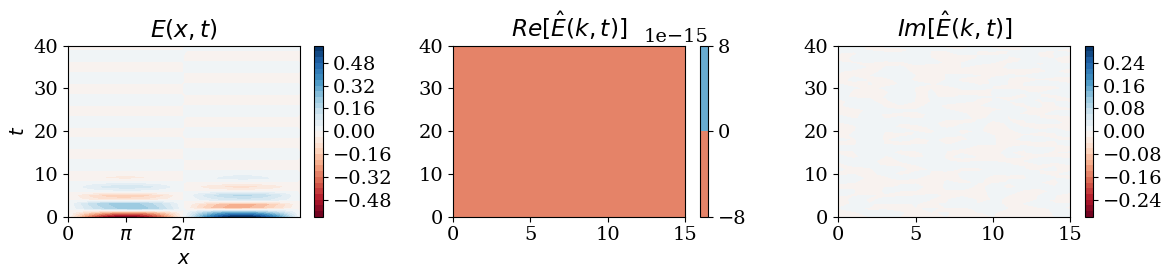

In [12]:
# plot the electric field
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
pos = ax[0].contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax[0].set_title("$E(x, t)$")
ax[0].set_xlabel("$x$")
_ = ax[0].set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax[0].set_ylabel("$t$")

pos = ax[1].contourf(np.arange(setup.Nx_total), sol_midpoint_t, E_midpoint_coeff.real.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax[1].set_xlim(0, 15)
ax[1].set_title("$Re[\hat{E}(k, t)]$")

pos = ax[2].contourf(np.arange(setup.Nx_total), sol_midpoint_t, E_midpoint_coeff.imag.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax[2].set_xlim(0, 15)
ax[2].set_title("$Im[\hat{E}(k, t)]$")

plt.tight_layout()
#plt.savefig("../figs/FOM/linear_landau/electric_field_FOM" + str(setup.Nv)+ ".png", dpi=600)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_53094/1301795918.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax.pcolormesh(np.arange(setup.Nv), sol_midpoint_t, np.log10(np.abs(sol_midpoint_u[np.arange(setup.Nx+1, (2*setup.Nx+1)*setup.Nv, 2*setup.Nx+1), :])).T, vmin=-5)


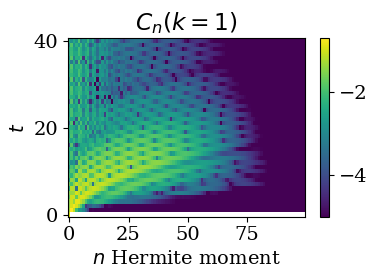

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))
pos = ax.pcolormesh(np.arange(setup.Nv), sol_midpoint_t, np.log10(np.abs(sol_midpoint_u[np.arange(setup.Nx+1, (2*setup.Nx+1)*setup.Nv, 2*setup.Nx+1), :])).T, vmin=-5)
cbar = fig.colorbar(pos)
ax.set_xlabel("$n$ Hermite moment")
ax.set_ylabel("$t$")
ax.set_title(r"$C_{n}(k=1)$")
plt.tight_layout()
plt.savefig("figs/nonlinear_landau/nonlinear_landau_moment_cascade_" + str(setup.Nv)+ "_closure_" + str(setup.closure_type) + "_collisions_" + str(setup.col_type) + ".png", dpi=200)

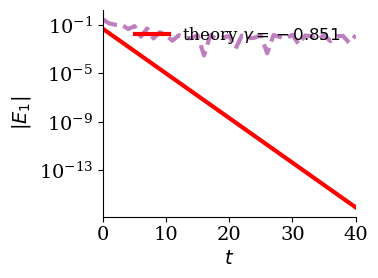

In [14]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(sol_midpoint_t, np.abs(E_midpoint_coeff[setup.Nx+1]), "--", c="purple", alpha=0.5, linewidth=3)
ax.plot(sol_midpoint_t, np.exp(-0.851*sol_midpoint_t)*5e-2, linewidth=3, color="red", label=r"theory $\gamma = -0.851$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|E_{1}|$")
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$ t$")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
#ax.set_xticks([0,5, 10, 15, 20])
plt.tight_layout()
plt.savefig("figs/nonlinear_landau/nonlinear_landau_electric_field_damping_" + str(setup.Nv)+ "_closure_" + str(setup.closure_type) + "_collisions_" + str(setup.col_type) + ".png", dpi=200)

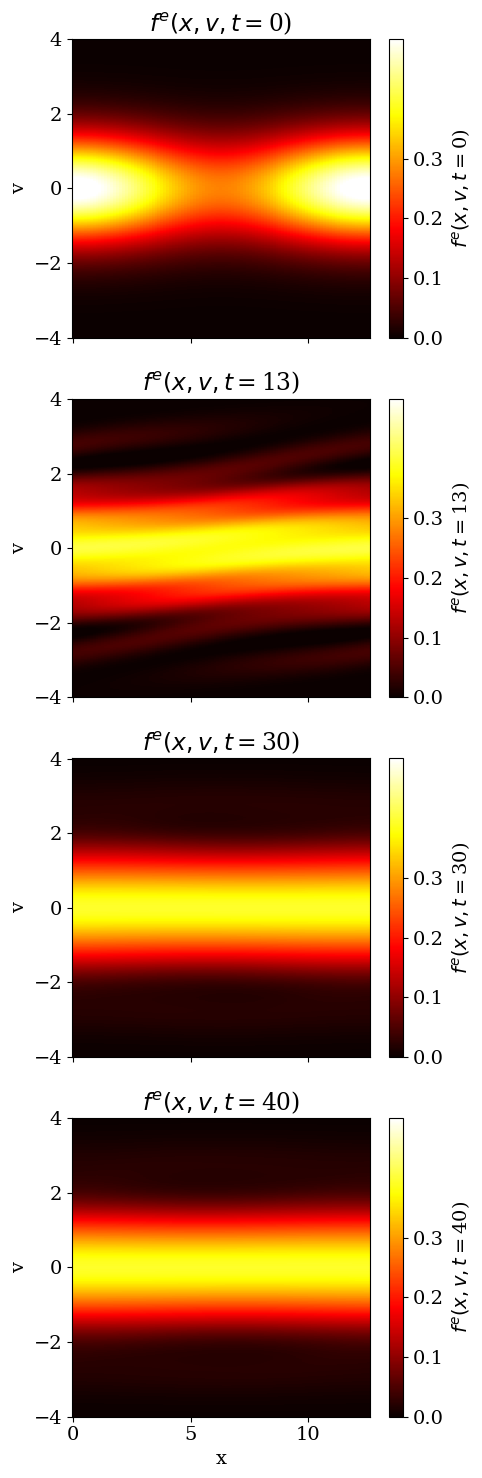

In [15]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=4, figsize=(5, 15), sharex=True)
for tt, ii in enumerate([0, len(sol_midpoint_t)//3, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv):
        distribution += np.outer(state_e_midpoint[jj, :, ii], psi_ln_aw(xi=(v - setup.u_e)/setup.alpha_e, v=v, u_s=setup.u_e, alpha_s=setup.alpha_e, n=jj))
    pos = ax[tt].pcolormesh(x, v, (distribution).T, cmap="hot", vmin=0, vmax=0.5, shading="nearest")
    #ax[tt].set_yticks([-3, 0, 3, 6])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")

ax[tt].set_xlabel("x")
#ax[tt].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
#ax[tt].set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
plt.tight_layout()
plt.savefig("figs/nonlinear_landau/nonlinear_landau_evolution_" + str(setup.Nv)+ "_closure_" + str(setup.closure_type) + "_collisions_" + str(setup.col_type) + ".png", dpi=600)

# conservation laws: mass, momentum, and energy

### mass conservation

In [15]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(psi=np.append(sol_midpoint_u[:, ii], C0_ions), 
                                   alpha_e=setup.alpha_e, alpha_i=setup.alpha_i, 
                                   L=setup.L, Nv=setup.Nv, Nx=setup.Nx).real

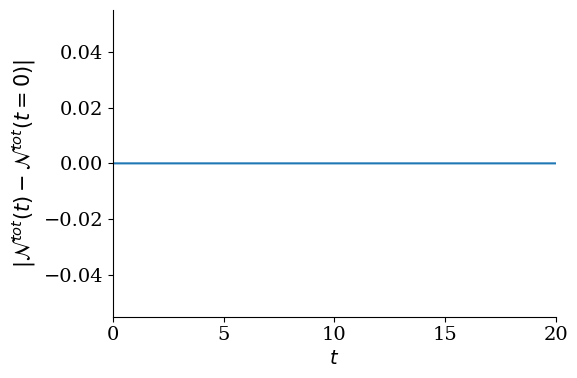

In [16]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [34]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(psi=np.append(sol_midpoint_u[:, ii], np.append(C0_ions, np.zeros(setup.Nx_total))), 
                                          alpha_e=setup.alpha_e, 
                                          alpha_i=setup.alpha_i, 
                                          Nv=setup.Nv, 
                                          Nx=setup.Nx, 
                                          L=setup.L, 
                                          m_i=setup.m_i, 
                                          m_e=setup.m_e,
                                          u_e=setup.u_e, 
                                          u_i=setup.u_i).real

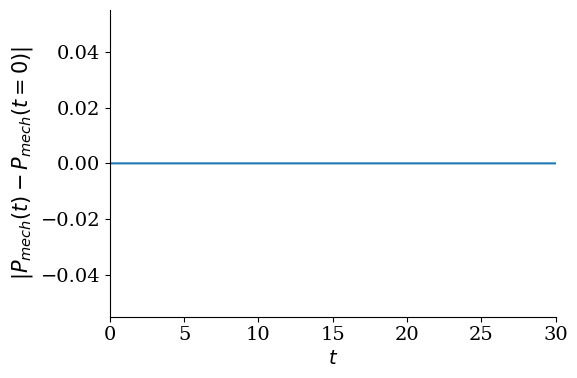

In [35]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [36]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(psi=np.append(sol_midpoint_u[:, ii], np.append(C0_ions, np.zeros(2*setup.Nx_total))), 
                                           alpha_e=setup.alpha_e,
                                           alpha_i=setup.alpha_i, 
                                           Nv=setup.Nv, 
                                           Nx=setup.Nx, 
                                           L=setup.L, 
                                           u_e=setup.u_e, 
                                           u_i=setup.u_i, 
                                           m_e=setup.m_e, 
                                           m_i=setup.m_i).real
    
    energy_p_midpoint[ii] = 0.5*setup.L*(np.sum(np.abs(E_midpoint_coeff[setup.Nx:, ii])**2) + np.sum(np.abs(np.conjugate(E_midpoint_coeff[setup.Nx + 1:, ii]))**2))

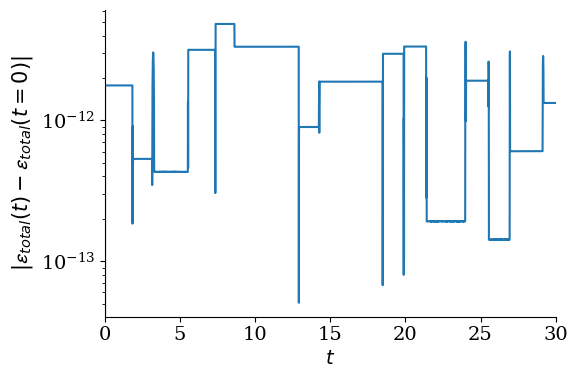

In [37]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

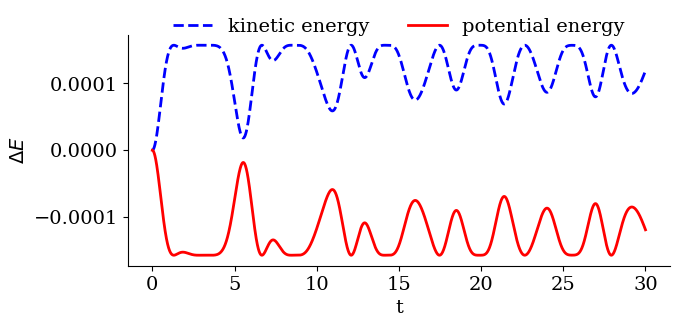

In [38]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
#ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

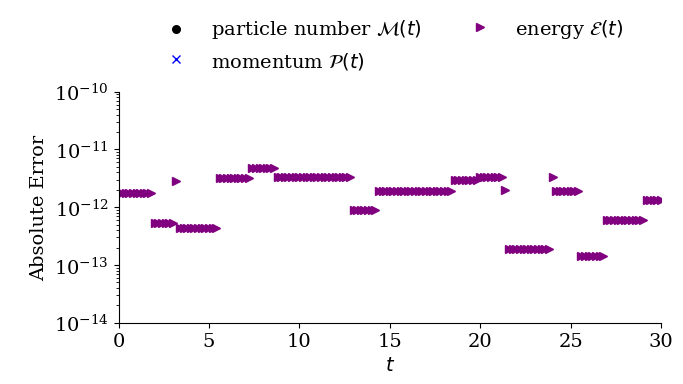

In [39]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.set_ylim(10**-14, 10**-10)
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
#plt.savefig("../figs/FOM/linear_landau/conservation_" + str(setup.Nv) + "_two_stream_FOM.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)